# Understanding Maji Ndogo's Agriculture

## Introduction

Maji Ndogo is a place with diverse and challenging agricultural landscapes. Before we dive into the 'how' of farming, we need to figure out the 'where' and 'what'. It's not just about deploying technology; it's about making informed decisions on where to plant specific crops, considering factors like rainfall, soil type, climate, and many others.

This analysis is the groundwork for the entire automation project. We have an array of variables like `soil fertility`, `climate conditions`, and `geographical` data. By understanding these elements, we can recommend the best locations for different crops. It's a bit like solving a complex puzzle – each piece of data is crucial to seeing the bigger picture.

We'll start by importing our dataset and transforming it into a Pandas DataFrame. It is currently in a SQLite database, and is split into separate tables. We expect a bit of a mess in the data – as it's part of the challenge. We need to clean it up and maybe reshape it to make sense of it. It's like sorting out the tools and materials we need and getting rid of what we don't.

We'll dive deep into the data, looking for patterns, and correlations. Each clue in the data leads us closer to understanding the best farming practices for Maji Ndogo. So without dallying, Let's dive into our data and see what stories it has to tell us 🤓.

## Data description

We are going to work with data from 4 tables in our SQLite Database and below is a brief overview and description of the entities and their attributes as they exist in the database:

**1. Geographic features**

- **Field_ID:** A unique identifier for each field (BigInt).
 
- **Elevation:** The elevation of the field above sea level in metres (Float).

- **Latitude:** Geographical latitude of the field in degrees (Float).

- **Longitude:** Geographical longitude of the field in degrees (Float).

- **Location:** Province the field is in (Text).

- **Slope:** The slope of the land in the field (Float).

**2. Weather features**

- **Field_ID:** Corresponding field identifier (BigInt).

- **Rainfall:** Amount of rainfall in the area in mm (Float).

- **Min_temperature_C:** Average minimum temperature recorded in Celsius (Float).

- **Max_temperature_C:** Average maximum temperature recorded in Celsius (Float).

- **Ave_temps:** Average temperature in Celcius (Float).

**3. Soil and crop features**

- **Field_ID:** Corresponding field identifier (BigInt).

- **Soil_fertility:** A measure of soil fertility where 0 is infertile soil, and 1 is very fertile soil (Float).

- **Soil_type:** Type of soil present in the field (Text).

- **pH:** pH level of the soil, which is a measure of how acidic/basic the soil is (Float).

**4. Farm management features**

- **Field_ID:** Corresponding field identifier (BigInt).

- **Pollution_level:** Level of pollution in the area where 0 is unpolluted and 1 is very polluted (Float).

- **Plot_size:** Size of the plot in the field (Ha) (Float).

- **Chosen_crop:** Type of crop chosen for cultivation (Text).

- **Annual_yield:** Annual yield from the field (Float). This is the total output of the field. The field size and type of crop will affect the Annual Yield

- **Standard_yield:** Standardised yield expected from the field, normalised per crop (Float). This is independent of field size, or crop type. Multiplying this number by the field size, and average crop yield will give the Annual_Yield.

**Average yield (tons/Ha) per crop type:**
- **Coffee:** 1.5 

- **Wheat:** 3

- **Rice:** 4.5

- **Maize:** 5.5

- **Tea:** 1.2

- **Potato:** 20

- **Banana:** 30

- **Cassava:** 13



## Notebook setup and data importation

First, let's importe our SQL data from multiple tables into a single pandas DataFrame. This is a crucial step as it sets the foundation for all our subsequent steps to analyse the data.

We're dealing with an SQLite database, `mn_farm_survey_small.db` in the `assets` folder, which contains multiple tables. We'll need to join these tables on a common key to create a comprehensive dataset for our analysis. The common key in our case is `Field_ID`.

In [1]:
# Import the necessary modules
import pandas as pd
from sqlalchemy import create_engine, text

# Create an engine for the database
engine = create_engine('sqlite:///../assets/data/mn_farm_survey_small.db') 

In [2]:
# Import numby for vectorized operations
import numpy as np

In [3]:
# Import matplotlib to visualize data
import matplotlib.pyplot as plt

Next up, we test if the connection works by printing out all of the table names in the database.

In [4]:
with engine.connect() as connection:
    result = connection.execute(text("SELECT name FROM sqlite_master WHERE type='table';"))
    for row in result:
        print(row)

('geographic_features',)
('weather_features',)
('soil_and_crop_features',)
('farm_management_features',)


At this point, we have two choices:

1. Either we import each table into a DataFrame, for example, `df_geographic`, then merge them together.

2. Use one SQL query and read it into a single DataFrame.

While both are equally viable, let's try to use a single SQL query to keep things simple.

Next, we'll write an SQL query to join our tables. Combine all of the tables into a single query, using `Field_ID`.

In [5]:
sql_query = """
SELECT
    * 
FROM 
    geographic_features
JOIN
    weather_features
    ON weather_features.Field_ID = geographic_features.Field_ID
JOIN
    soil_and_crop_features
    ON soil_and_crop_features.Field_ID = geographic_features.Field_ID
JOIN
    farm_management_features
    ON farm_management_features.Field_ID = geographic_features.Field_ID;
"""

With our engine and query ready, we'll use `Pandas` to execute the query. The `pd.read_sql_query` function fetches the data and loads it into a DataFrame – essentially transferring our data from the database into a familiar `Pandas` structure. If you use one query, you will import it all into `MD_agric_df`. 

In [6]:
# Create a connection object
with engine.connect() as connection:
    
    # Use Pandas to execute the query and store the result in a DataFrame
    MD_agric_df = pd.read_sql_query(text(sql_query), connection)

Check the DataFrame to see if it loaded correctly.

In [7]:
MD_agric_df.head()

,Field_ID,Elevation,Latitude,Longitude,Location,Slope,Field_ID,Rainfall,Min_temperature_C,Max_temperature_C,...,Field_ID,Soil_fertility,Soil_type,pH,Field_ID,Pollution_level,Plot_size,Crop_type,Annual_yield,Standard_yield
0,40734,786.05580,-7.389911,-7.556202,Rural_Akatsi,14.795113,40734,1125.2,-3.1,33.1,...,40734,0.62,Sandy,6.169393,40734,0.085267,1.3,0.751354,cassava,0.577964
1,30629,674.33410,-7.736849,-1.051539,Rural_Sokoto,11.374611,30629,1450.7,-3.9,30.6,...,30629,0.64,Volcanic,5.676648,30629,0.399684,2.2,1.069865,cassava,0.486302
2,39924,826.53390,-9.926616,0.115156,Rural_Sokoto,11.339692,39924,2208.9,-1.8,28.4,...,39924,0.69,Volcanic,5.331993,39924,0.358029,3.4,2.208801,tea,0.649647
3,5754,574.94617,-2.420131,-6.592215,Rural_Kilimani,7.109855,5754,328.8,-5.8,32.2,...,5754,0.54,Loamy,5.328150,5754,0.286687,2.4,1.277635,cassava,0.532348
4,14146,886.35300,-3.055434,-7.952609,Rural_Kilimani,55.007656,14146,785.2,-2.5,31.0,...,14146,0.72,Sandy,5.721234,14146,0.043190,1.5,0.832614,wheat,0.555076


Note that there are a couple of `Field_ID` columns in our DataFrame that we need to remove since we're not interested in particular farms for now.

In [8]:
# Now, drop all columns named 'Field_ID'.
MD_agric_df.drop(columns = 'Field_ID', inplace = True)

# Data cleaning

Let us first inspect the data to see whether there are some inequities that need rectification before we continue with our data exploration. For accurate analysis, we need clean data and that's what we are going to embark on in this section.

In [9]:
# Inspect basic info on the dataframe
MD_agric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5654 entries, 0 to 5653
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Elevation          5654 non-null   float64
 1   Latitude           5654 non-null   float64
 2   Longitude          5654 non-null   float64
 3   Location           5654 non-null   object 
 4   Slope              5654 non-null   float64
 5   Rainfall           5654 non-null   float64
 6   Min_temperature_C  5654 non-null   float64
 7   Max_temperature_C  5654 non-null   float64
 8   Ave_temps          5654 non-null   float64
 9   Soil_fertility     5654 non-null   float64
 10  Soil_type          5654 non-null   object 
 11  pH                 5654 non-null   float64
 12  Pollution_level    5654 non-null   float64
 13  Plot_size          5654 non-null   float64
 14  Crop_type          5654 non-null   float64
 15  Annual_yield       5654 non-null   object 
 16  Standard_yield     5654 

We see that most of our columns are contain numerical values except for `Location`, `Soil_type` and `Annual_yield` 🤔🤷🏽‍♂️!? We'll circle back to that in a bit. Let's get the descriptive statistics of our numerical columns and see if we can find something unusual.

In [10]:
# Disoplay descriptive statistics on numerical columns
MD_agric_df.describe()

,Elevation,Latitude,Longitude,Slope,Rainfall,Min_temperature_C,Max_temperature_C,Ave_temps,Soil_fertility,pH,Pollution_level,Plot_size,Crop_type,Standard_yield
count,5654.000000,5654.000000,5654.000000,5654.000000,5654.000000,5654.000000,5654.000000,5654.000000,5654.000000,5654.000000,5.654000e+03,5654.000000,5654.000000,5654.000000
mean,625.468485,-7.026330,-4.365755,11.742669,1201.943244,-4.411956,30.857057,13.222550,0.619308,5.607073,2.231923e-01,3.923965,2.090399,0.534405
std,213.768160,3.515839,2.706603,9.540599,499.782824,1.534330,1.884682,0.801636,0.044791,0.789215,2.237976e-01,3.463855,1.935000,0.111806
min,-878.860800,-15.009038,-10.015722,0.097316,103.100000,-9.700000,24.500000,10.250000,0.510000,3.700337,1.013245e-10,0.500000,0.172226,0.170717
25%,520.125410,-9.674298,-6.708209,4.860120,773.175000,-5.500000,29.600000,12.700000,0.590000,5.030630,5.133734e-02,1.500000,0.767032,0.460386
50%,661.308975,-7.205178,-4.463785,9.104626,1200.600000,-4.300000,30.800000,13.200000,0.620000,5.602896,1.647056e-01,2.800000,1.446648,0.528836
75%,763.366200,-4.182984,-2.015527,15.953242,1625.425000,-3.300000,32.100000,13.750000,0.650000,6.162058,3.058885e-01,4.700000,2.530662,0.599942
max,1122.252100,0.260756,1.696276,79.865960,2470.900000,-0.100000,37.800000,17.300000,0.820000,7.499959,9.954134e-01,15.000000,12.695224,0.898037


If we observe the Elevation column, our statistics tell us that there's a negative minimum value, which means that the column probably has some negative values which are not plausible so we'll just change those back to positive values. Let's get a pick of the head just to see what's with the `Annual_yield` column being a text column.

In [11]:
# Inspect the last three columns in the dataframe
MD_agric_df.loc[:5, 'Crop_type':]

,Crop_type,Annual_yield,Standard_yield
0,0.751354,cassava,0.577964
1,1.069865,cassava,0.486302
2,2.208801,tea,0.649647
3,1.277635,cassava,0.532348
4,0.832614,wheat,0.555076
5,1.112611,potato,0.654477


We can see mismatched column values with regard to their column names i.e `Crop_type` and `Annual_yield`. We'll assume that those columns were swapped during data entry. Let's go ahead and check what kind of values we have in the `Annual_yield` column which we will have to rename to `Crop_type` since it makes much more intuitive sense.

In [12]:
# Inspect the unique values in 'Annual_yield' which should be 'Crop_type`
MD_agric_df['Annual_yield'].unique()

array(['cassava', 'tea', 'wheat', 'potato', 'banana', 'coffee', 'rice',
       'maize', 'wheat ', 'tea ', 'cassaval', 'wheatn', 'cassava ',
       'teaa'], dtype=object)

Alright, so far, Here's the list of things that we picked up from the data and what we need to do:

1. There are some swapped column names i.e `Crop_type` and `Annual_yield`. We need to swap those back. 

2. Some of the crop types contain spelling errors and so we need to rectify those as well.

3.  The `Elevation` column contains some negative values, which are not plausible, so we need to change these to positive values.

In [13]:
# rename swapped column names
MD_agric_df = MD_agric_df.rename(columns={'Crop_type': 'Annual_yield', 
                                          'Annual_yield': 'Crop_type'})

# Clean the spelling errors in crop types column
MD_agric_df['Crop_type'] = MD_agric_df['Crop_type'].map(
    {'cassaval': 'cassava', 
     'wheatn': 'wheat', 
     'teaa': 'tea'}).fillna(MD_agric_df['Crop_type']).apply(lambda x: x.strip())

# Update the negative values in Elevation column to positive values
MD_agric_df['Elevation'] = MD_agric_df['Elevation'].apply(lambda x: abs(x))

## Final data checkup

Let's do a final data checkup to ensure that we successfully managed to clean and standardize our data.

In [14]:
print(MD_agric_df['Crop_type'].unique())
print("Unique crop types:", len(MD_agric_df['Crop_type'].unique()))

['cassava' 'tea' 'wheat' 'potato' 'banana' 'coffee' 'rice' 'maize']
Unique crop types: 8


In [15]:
MD_agric_df['Elevation'].min()

35.910797

In [16]:
MD_agric_df['Annual_yield'].dtype

dtype('float64')

Great, we've managed to rename the columns and values, and done away with negative elevation values and we can proceed to exploratory data analysis.

## Exploratory Data Analysis (EDA)

### Uncovering crop preferences

Now that we have our data ready, let's delve into understanding where different crops are grown in Maji Ndogo. Our initial step is to focus on tea, a key crop in Maji Ndogo. We need to determine the optimal conditions for its growth. By analyzing data related to elevation, rainfall, and soil type specifically for tea plantations, we'll start to paint a picture of where our farming systems could thrive.

**Task:**
Let's create a function that includes only tea fields and returns a tuple with the mean `Rainfall` and the mean `Elevation`. The function should consume the full DataFrame object, a string value for the crop type to filter by, and output a tuple with rainfall and elevation averages.


In [17]:
def explore_crop_distribution(df,crop_filter):
    # Filter the dataframe for the crop type
    crop_filtered_df = df[df['Crop_type'] == crop_filter]
    
    # Compute the average rainfall and elevation for the filtered crop
    mean_rainfall = crop_filtered_df['Rainfall'].mean()
    mean_elevation = crop_filtered_df['Elevation'].mean()
    
    # Return a tuple of the average rainfall and elevation
    return mean_rainfall, mean_elevation

Great, we've created a function that would compute the average downpoor and elevations for a specific crop. Let's test our model out on `tea` and `wheat`.

In [18]:
# Get the average rainfall and elevation for the tea crop
avg_rainfall_tea, avg_elevation_tea = explore_crop_distribution(MD_agric_df, "tea")
print("Tea:")
print("Avg. Rainfall:", avg_rainfall_tea)
print("Avg. Elevation:", avg_elevation_tea)

Tea:
Avg. Rainfall: 1534.5079956188388
Avg. Elevation: 775.208667535597


In [19]:
# Get the average rainfall and elevation for the wheat crop
avg_rainfall_wheat, avg_elevation_wheat = explore_crop_distribution(MD_agric_df, "wheat")
print("Wheat:")
print("Avg. Rainfall:", avg_rainfall_wheat)
print("Avg. Elevation:", avg_elevation_wheat)

Wheat:
Avg. Rainfall: 1010.2859910581222
Avg. Elevation: 595.8384148002981


Great, we have verified that our function works. Let's create a function to do for all the crop types so that we can compare the rainfall and elevation averages per crop type.

In [20]:
# Compute each crop type's average rainfall and elevation
avg_rain_elev = MD_agric_df.groupby('Crop_type')[['Rainfall', 'Elevation']].mean()
avg_rain_elev

,Rainfall,Elevation
Crop_type,,
banana,1659.905687,487.973572
cassava,1210.543006,682.903008
coffee,1527.265074,647.047734
maize,681.010276,680.596982
potato,660.289064,696.313917
rice,1632.382642,352.858053
tea,1534.507996,775.208668
wheat,1010.285991,595.838415


### Finding fertile grounds


With insights into tea cultivation, let's broaden our horizons. Fertile soil is the bedrock of successful farming. By grouping our data by location and soil type, we'll pinpoint where the most fertile soils in Maji Ndogo are. These fertile zones could be prime candidates for diverse crop cultivation, maximising our yield.

We’ll group our data by soil type to see where the most fertile grounds are. This information will be vital for deciding where to deploy our farming technology.

**Task:** Let's create a function that groups the data by `Soil_type`, and returns the `Soil_fertility`.

In [21]:

def analyse_soil_fertility(df):
    # group by the dataframe by the soil type and aggregate by avg soil fertility
    return df.groupby('Soil_type')['Soil_fertility'].mean()


In [22]:
# Analyse Maji Ndogo's soil fertility per soil type
analyse_soil_fertility(MD_agric_df)

Soil_type
Loamy       0.585868
Peaty       0.604882
Rocky       0.582368
Sandy       0.595669
Silt        0.652654
Volcanic    0.648894
Name: Soil_fertility, dtype: float64

Let's dig deeper into the data by aggregating various variables to identify some more patterns across the soil types. Let's edit the function above to make it more flexible in analysing numerical values across the `Soil_type`s. We'll compute the `mean`, `median` and `std` just to see where each aspect of the soil types is centralised and how the aspect is dispersed away from the aggregated central point i.e. `mean`

In [23]:
def analyse_soil_types(df, *features):
    # Group the df by the soil type and aggregate by avg of any numeric feature
    return df.groupby('Soil_type')[list(features)].agg(['mean', 'median', 'std'])

In [24]:
# Return the avg and variance of elevations across soil types
analyse_soil_types(MD_agric_df, 'Rainfall', 'Elevation', 'Soil_fertility')

Rainfall                        Elevation             \
                  mean   median         std        mean     median   
Soil_type                                                            
Loamy       724.785612   714.80  305.974138  552.383554  570.07544   
Peaty      1344.381176  1338.85   87.337097  467.291922  495.76023   
Rocky       841.874671   824.55  174.990128  892.665740  880.35557   
Sandy       797.665003   782.80  228.927365  743.456509  738.13340   
Silt       1667.228365  1672.40  178.134957  424.196238  429.51413   
Volcanic   1630.504364  1555.50  322.676943  750.902092  743.75665   

                      Soil_fertility                   
                  std           mean median       std  
Soil_type                                              
Loamy       66.002101       0.585868   0.59  0.034232  
Peaty      127.181470       0.604882   0.61  0.006549  
Rocky       46.696492       0.582368   0.58  0.017622  
Sandy       72.548232       0.595669   0.59  0.036986  
Silt       126.508846       0.652654   0.65  0.028228  
Volcanic    73.618582       0.648894   0.64  0.037624

Silt and volcanic soil types appear to be the most fertile of soil types, on average. The spread of the `soil_fertility` score across soil types seems to be  normally distributed and symmetrically dispersed around the mean so we can trust the average scores.

On average, the silt soil type is found on lower altitudes compared to volcanic, however the spread of the altitudes around the mean is greater relative to the altitudes for other crop types. It is also skewed towards the right meaning that there are areas in very low altitudes that have the silt soil type. Peaty soli type also seems to have an almost similar tendancy as the silt soil with regard to elevation. Volcanic, sandy and rocky sand types are consistently found in higher altitudes.  

The spread of rainfall in volcanic soil areas is great and the distribution seems to be skewed towards the right hence we'll have to consider the median as well. The summary statistics tell us that the volcanic soil type generally receive lower rainfall relative to silt soil but there are a few areas with volcanic soil that recieve a lot of rainfall. The Silt soil areas seem to receive higher amounts of rainfall, on average, compared to all other soil types with pretty much less standard deviation which means that the expected rainfall in silt soil areas is much more predictable.

Let's visualize scatter plot's for these features and see if they have linear relationships.

In [25]:
def filter_data(df, primary_variable, primary_var_value, *secondary_variables):
    """
    Filter data according to a primary variable and it's values and any number of seconday variables
    """
    primary_filtered_df = df[df[primary_variable] == primary_var_value]
    result_df = primary_filtered_df[secondary_variables[0] if len(secondary_variables) < 2 else list(secondary_variables)]
    return result_df

In [26]:
# Get the variables whose relations we want to investigate
elevation = MD_agric_df['Elevation']
rainfall = MD_agric_df['Rainfall']
soil_fertility = MD_agric_df['Soil_fertility']

In [27]:
# Get the variables above for silt and volcanic soil types
silt = filter_data(MD_agric_df, 'Soil_type', 'Silt', 'Elevation', 'Rainfall', 'Soil_fertility')
volcanic = filter_data(MD_agric_df, 'Soil_type', 'Volcanic', 'Elevation', 'Rainfall', 'Soil_fertility')

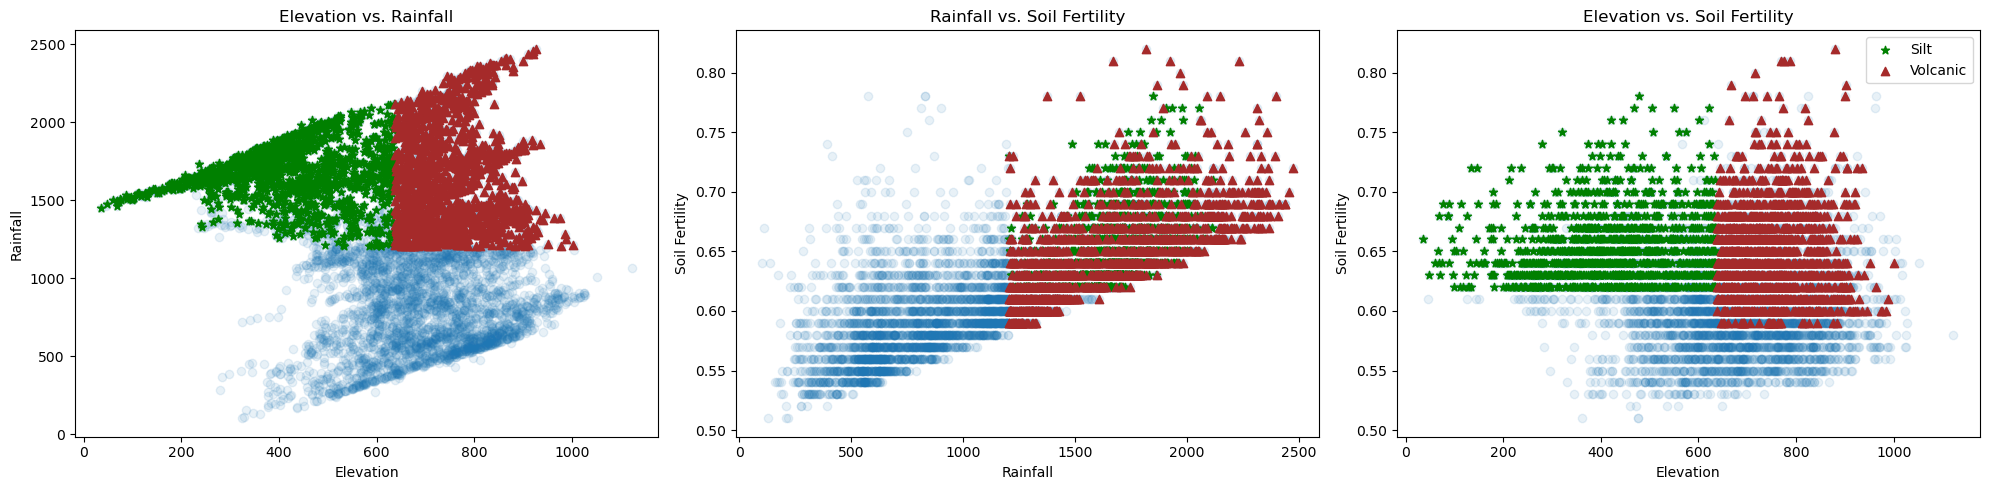

In [28]:
# Create a subplot of three plots 
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Visualize the relationship between Elevation and Rainfall
axs[0].scatter(MD_agric_df['Elevation'], MD_agric_df['Rainfall'], alpha=0.1)
axs[0].scatter(silt['Elevation'], silt['Rainfall'], label="Silt", color="green", marker="*")
axs[0].scatter(volcanic['Elevation'], volcanic['Rainfall'], label="Volcanic", color="brown", marker="^")
axs[0].set_title('Elevation vs. Rainfall')
axs[0].set_xlabel('Elevation')
axs[0].set_ylabel('Rainfall')

# Visualize the relationship between rainfall and soil fertility
axs[1].scatter(MD_agric_df['Rainfall'], MD_agric_df['Soil_fertility'], alpha=0.1)
axs[1].scatter(silt['Rainfall'], silt['Soil_fertility'], label="Silt", color="green", marker="*")
axs[1].scatter(volcanic['Rainfall'], volcanic['Soil_fertility'], label="Volcanic", color="brown", marker="^")
axs[1].set_title('Rainfall vs. Soil Fertility')
axs[1].set_xlabel('Rainfall')
axs[1].set_ylabel('Soil Fertility')

# Visualize the relationship between elevation and soil fertility
axs[2].scatter(MD_agric_df['Elevation'], MD_agric_df['Soil_fertility'], alpha=0.1)
axs[2].scatter(silt['Elevation'], silt['Soil_fertility'], label="Silt", color="green", marker="*")
axs[2].scatter(volcanic['Elevation'], volcanic['Soil_fertility'], label="Volcanic", color="brown", marker="^")
axs[2].set_title('Elevation vs. Soil Fertility')
axs[2].set_xlabel('Elevation')
axs[2].set_ylabel('Soil Fertility')



# Add the legend to the plot
plt.legend()

# Adjust the layout of the subplots
plt.tight_layout()

# Display the plot
plt.show()


In [29]:
# Get the pearson's correlation coefficient between the three variables
elevation_rainfall_corr = MD_agric_df['Rainfall'].corr(MD_agric_df['Elevation'])
rainfall_soil_fertility_corr = MD_agric_df['Rainfall'].corr(MD_agric_df['Soil_fertility'])
elevation_soil_fertility_corr = MD_agric_df['Elevation'].corr(MD_agric_df['Soil_fertility'])

print("Elevation vs. Rainfall:", elevation_rainfall_corr)
print("Rainfall vs. Soil fertility:", rainfall_soil_fertility_corr)
print("Elevation vs. Soil fertility:", elevation_soil_fertility_corr)

Elevation vs. Rainfall: -0.23851800235487727
Rainfall vs. Soil fertility: 0.7529142401858635
Elevation vs. Soil fertility: -0.14684365809653746


From the visualisation above, we summarize the following about the relationship between the three variables:
- `Elevation` and `Rainfall` shows a slight positive correlation but if we check their pearson's correlation coeffecient, we see a weak negative correlation between the two variables. Moreover, as demonstrated across `Silt` and `Volcanic` soil types, The amount of rainfall does vary across areas of the same elevation for areas with both `Silt` and `Volcanic` soilt types which means there isn't any strong linear relationship between `Elevation` and `Rainfall`.

- The `Rainfall` and `Soil_fertility` features however display a very strong positive correlation also captured by pearson's correlation coefficient of `~0.75`. This might mean that in general, The soil fertility gets better with an increase in rainfall. We also see that our most fertile soil types are concentrated in areas that receive higher amounts of rainfall.

- The third plot also shows us that there's no linear relationship between `Elevation` and `Soil_fertility`. This can also be explained by the first plot where we see both `Silt` and `Volcanic` soil types being the most fertile soil types with the latter spread across lower altitudes compared to the former.

### Climate and geography analysis

Now, let's delve into how climate and geography influence farming. By understanding the relationship between factors like **elevation**, **temperature**, and **rainfall** with **crop yields**, we can identify the most suitable areas for different crops. This analysis is key to ensuring our automated systems are deployed in locations that will maximise their effectiveness.

**Task:** Create a function that takes in a DataFrame and the column name, and groups the data by that column, and aggregates the data by the means of `Elevation`, `Min_temperature_C`, `Max_temperature_C`, and `Rainfall`, and outputs a DataFrame. Please ensure that the order of the columns matches the output.

In [30]:
MD_agric_df.columns

Index(['Elevation', 'Latitude', 'Longitude', 'Location', 'Slope', 'Rainfall',
       'Min_temperature_C', 'Max_temperature_C', 'Ave_temps', 'Soil_fertility',
       'Soil_type', 'pH', 'Pollution_level', 'Plot_size', 'Annual_yield',
       'Crop_type', 'Standard_yield'],
      dtype='object')

In [31]:
def climate_geography_influence(df,column):
    return df.groupby(column).agg(
        {'Elevation': 'mean', 
         'Min_temperature_C': 'mean', 
         'Max_temperature_C': 'mean', 
         'Rainfall': 'mean'})

In [32]:
climate_geography_influence(MD_agric_df, 'Crop_type')

,Elevation,Min_temperature_C,Max_temperature_C,Rainfall
Crop_type,,,,
banana,487.973572,-5.354344,31.988152,1659.905687
cassava,682.903008,-3.992113,30.902381,1210.543006
coffee,647.047734,-4.028007,30.855189,1527.265074
maize,680.596982,-4.497995,30.576692,681.010276
potato,696.313917,-4.375334,30.300608,660.289064
rice,352.858053,-6.610566,32.727170,1632.382642
tea,775.208668,-2.862651,29.950383,1534.507996
wheat,595.838415,-4.968107,30.973845,1010.285991


We already saw that there is no relationship between `Elevation` and `Rainfall` but what's the correlation of `Elevation` to `Min_temperature_C`, `Max_temperature_C` and `Ave_temps`. 

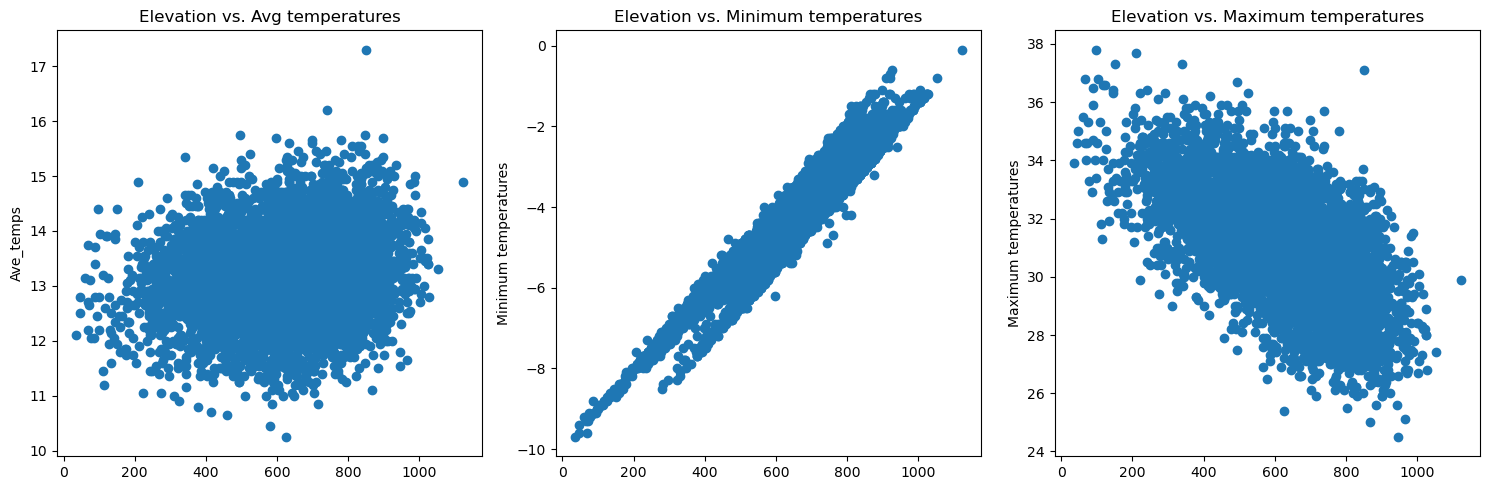

In [33]:
# Create a plot with subplots comparing the correlation of elevation and the temperature features
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Create a scatter plot of elevation and ave_temps
axs[0].scatter(MD_agric_df['Elevation'], MD_agric_df['Ave_temps'])
axs[0].set_title("Elevation vs. Avg temperatures")
axs[0].set_ylabel("Ave_temps")

# Add a scatter plot of elevation vs min_temperature_c
axs[1].scatter(MD_agric_df['Elevation'], MD_agric_df['Min_temperature_C'])
axs[1].set_title("Elevation vs. Minimum temperatures")
axs[1].set_ylabel("Minimum temperatures")

# Add a scatter plot of elevation vs max_temperature_c
axs[2].scatter(MD_agric_df['Elevation'], MD_agric_df['Max_temperature_C'])
axs[2].set_title("Elevation vs. Maximum temperatures")
axs[2].set_ylabel("Maximum temperatures")

# Adjust the layout of the plot
plt.tight_layout()

# Display the plot
plt.show()

In [34]:
# Let's calculate the correlation coefficients between the three variables
elevation_avg_temps_corr = MD_agric_df['Elevation'].corr(MD_agric_df['Ave_temps'])
elevation_min_temps_corr = MD_agric_df['Elevation'].corr(MD_agric_df['Min_temperature_C'])
elevation_max_temps_corr = MD_agric_df['Elevation'].corr(MD_agric_df['Max_temperature_C'])

# Display their correlation coefficients
print("Elevation vs. Avg temps:", elevation_avg_temps_corr)
print("Elevation vs. Min temperatures:", elevation_min_temps_corr)
print("Elevation vs. Max temperatures:", elevation_max_temps_corr)

Elevation vs. Avg temps: 0.20306114718387713
Elevation vs. Min temperatures: 0.9564181399438543
Elevation vs. Max temperatures: -0.6058837827638006


We can see from the scatter visualizations and their correlation coefficients that the `Elevation` is positively and strongly correlated to the `Min_temperature_C` feature. It also has a relatively visible negative correlation with `Max_temprature_C`. These two visualisations might hint at the predictability of Minimum tempratures across different elevations compared to Maximum tempratures. 

### What's the top performing crop?

Quite often it is better to improve the things you're good at than improving the things you're bad at. So the question is, which crop is the top performer in Maji Ndogo, and under what conditions does it perform well? 

To answer this, we need to:
1. Filter all the fields with an above-average `Standard_yield`.
2. Then aggregate by the `count()`s of crop type.
3. Sort the values to get the top crop type on top.
4. Retrieve the name of the top index. 

**Task:** Let's create a function that takes a DataFrame object as input, filters, groups and sorts, and outputs a string value of a crop type.

In [35]:
def find_ideal_fields(df):
    # Filter all the observations with above avg. standard yield
    above_std_yield = df[df['Standard_yield'] > df['Standard_yield'].mean()]
    # Group the filtered data per crop type, count and sort the crop types in descending order
    best_performing_crops = above_std_yield.groupby('Crop_type')['Crop_type'].count().sort_values(ascending=False)
    # # Get the top performing crop
    # top_performing_crop = best_performing_crops.index[0]
    return best_performing_crops

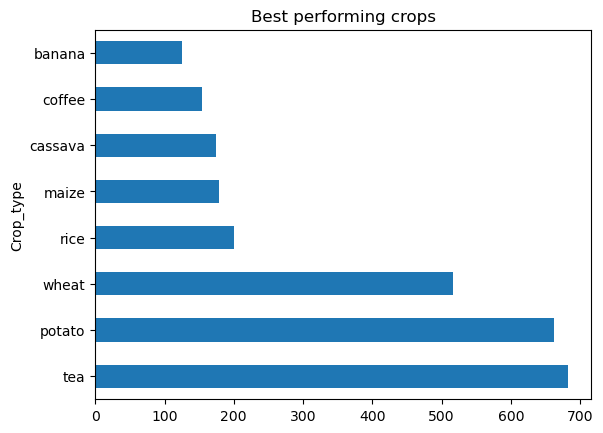

In [36]:
# Visualize the best performing crops
find_ideal_fields(MD_agric_df).plot(kind="barh")
plt.title("Best performing crops")
plt.show()

### What conditions favour our star crop?

Now we know that tea is our most successful crop, we can look at what makes it successful.

Create a function that takes a DataFrame as input, and the type of crop, and filters the DataFrame using the following conditions:
1. Filter by crop type.

2. Select only rows that have above average `Standard_yield`.

3. Select only rows that have `Ave_temps` >= 12 but =< 15.

4. Have a `Pollution_level` lower than 0.0001.

In [37]:
def find_good_conditions(df, crop_type):
    # Filter the dataframe against the crop type
    ctype_df = df[df['Crop_type'] == crop_type]
    # Filter the crop type df for those with above standard yield
    above_std_yield = ctype_df[ctype_df['Standard_yield'] > ctype_df['Standard_yield'].mean()]
    # Filter the resulting df for ave_temps between 12 and 15 inclusive
    temps_df = above_std_yield[(above_std_yield['Ave_temps'] >= 12) & (above_std_yield['Ave_temps'] <= 15)]
    # Filter the resulting df for pollution_levels lower than 0.0001
    final_df = temps_df[temps_df['Pollution_level'] < 0.0001]
    return final_df

In [38]:
tea_conditions = find_good_conditions(MD_agric_df, 'tea')
tea_conditions.shape

(14, 17)